In [2]:
# setup
from mlwp import *
%matplotlib inline

iris = datasets.load_iris()

tts = skms.train_test_split(iris.data, iris.target,
        test_size=.33, random_state=21)

(iris_train_ftrs, iris_test_ftrs,
iris_train_tgt,iris_test_tgt) = tts

In [4]:
# normal usage:build-fit-predict-evaluate
baseline = dummy.DummyClassifier(strategy="most_frequent")
baseline.fit(iris_train_ftrs, iris_train_tgt)
base_preds = baseline.predict(iris_test_ftrs)
base_acc = metrics.accuracy_score(base_preds, iris_test_tgt)
print(base_acc)

0.3


In [5]:
strategies = ['constant', 'uniform', 'stratified',
                'prior', 'most_frequent']

# set up args to create different DummyClassifier strategies
baseline_args = [{'strategy':s} for s in strategies]
baseline_args[0]['constant'] = 0 # class 0 is setosa
accuracies = []
for bla in baseline_args:
    baseline = dummy.DummyClassifier(**bla)
    baseline.fit(iris_train_ftrs, iris_train_tgt)
    base_preds = baseline.predict(iris_test_ftrs)
    accuracies.append(metrics.accuracy_score(base_preds, iris_test_tgt))

display(pd.DataFrame({'accuracy':accuracies}, index=strategies))

,accuracy
constant,0.3600
uniform,0.3800
stratified,0.3400
prior,0.3000
most_frequent,0.3000


In [7]:
knn = neighbors.KNeighborsClassifier()
# help(knn.score) # verbose, but complete
print(knn.score.__doc__.splitlines()[0])
print('\n---and---\n')
print("\n".join(knn.score.__doc__.splitlines()[-6:]))



---and---


        Returns
        -------
        score : float
            Mean accuracy of ``self.predict(X)`` w.r.t. `y`.
        


In [9]:
tgt_preds = (neighbors.KNeighborsClassifier()
            .fit(iris_train_ftrs, iris_train_tgt)
            .predict(iris_test_ftrs))
print("accuracy:", metrics.accuracy_score(iris_test_tgt,
                        tgt_preds))
cm = metrics.confusion_matrix(iris_test_tgt,
                                    tgt_preds)
print("confusion matrix:", cm, sep="\n")

accuracy: 0.94
confusion matrix:
[[18  0  0]
 [ 0 16  1]
 [ 0  2 13]]


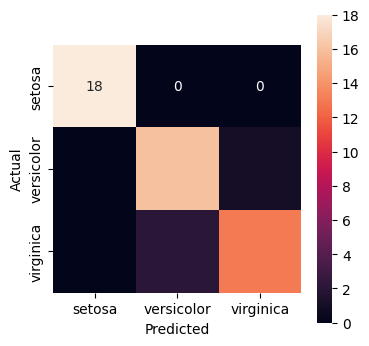

In [10]:
fig, ax = plt.subplots(1, 1, figsize=(4, 4))
cm = metrics.confusion_matrix(iris_test_tgt, tgt_preds)
ax = sns.heatmap(cm, annot=True, square=True,
                xticklabels=iris.target_names,
                yticklabels=iris.target_names)
ax.set_xlabel('Predicted')
ax.set_ylabel('Actual');

In [11]:
macro_prec = metrics.precision_score(iris_test_tgt,
                            tgt_preds,
                            average='macro')

print("macro:", macro_prec)

cm = metrics.confusion_matrix(iris_test_tgt, tgt_preds)
n_labels = len(iris.target_names)
print("should equal 'macro avg':",
      
        # correct       column          # columns
        (np.diag(cm) / cm.sum(axis=0)).sum() / n_labels)

macro: 0.9391534391534391
should equal 'macro avg': 0.9391534391534391


In [12]:
print("micro:", metrics.precision_score(iris_test_tgt,
                                    tgt_preds,
                                    average='micro'))

cm = metrics.confusion_matrix(iris_test_tgt, tgt_preds)
print("should equal avg='micro':",
    # TP.sum()/ (TP&FP).sum() -->
    # all correct/ all preds
    np.diag(cm).sum() / cm.sum())

micro: 0.94
should equal avg='micro': 0.94


In [13]:
print(metrics.classification_report(iris_test_tgt,
                                        tgt_preds)) 
# average is a weighted macro average (see text)
# verify sums-across-rows
cm = metrics.confusion_matrix(iris_test_tgt, tgt_preds)
print("row counts equal support:", cm.sum(axis=1))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00        18
           1       0.89      0.94      0.91        17
           2       0.93      0.87      0.90        15

    accuracy                           0.94        50
   macro avg       0.94      0.94      0.94        50
weighted avg       0.94      0.94      0.94        50

row counts equal support: [18 17 15]


In [16]:
#warning: this is 1 "one" not l "ell"

is_versicolor = iris.target == 1

tts_1c = skms.train_test_split(iris.data, is_versicolor,
                        test_size=.33, random_state = 21)

(iris_1c_train_ftrs, iris_1c_test_ftrs,
    iris_1c_train_tgt,iris_1c_test_tgt) = tts_1c

# build, fit, predict (probability scores) for NB model
gnb = naive_bayes.GaussianNB()
prob_true = (gnb.fit(iris_1c_train_ftrs, iris_1c_train_tgt)
                .predict_proba(iris_1c_test_ftrs)[:, 1]) # [:, 1]=="True"

FPR : [0.     0.     0.     0.0606 0.0606 0.1212 0.1212 0.1818 1.    ]
TPR : [0.     0.0588 0.8824 0.8824 0.9412 0.9412 1.     1.     1.    ]


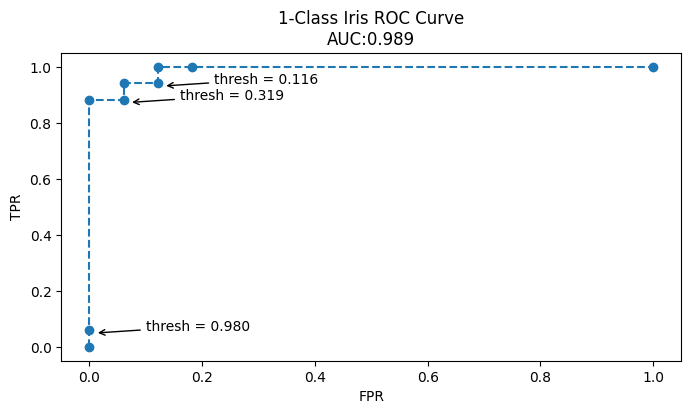

In [17]:
fpr, tpr, thresh = metrics.roc_curve(iris_1c_test_tgt,
                                        prob_true)
auc = metrics.auc(fpr, tpr)

print("FPR : {}".format(fpr),
        "TPR : {}".format(tpr), sep='\n')
# create the main graph
fig, ax = plt.subplots(figsize=(8, 4))
ax.plot(fpr, tpr, 'o--')
ax.set_title("1-Class Iris ROC Curve\nAUC:{:.3f}".format(auc))
ax.set_xlabel("FPR")
ax.set_ylabel("TPR");

# do a bit of work to label some points with their
# respective thresholds
investigate = np.array([1, 3, 5])
for idx in investigate:
    th, f, t = thresh[idx], fpr[idx], tpr[idx]
    ax.annotate('thresh = {:.3f}'.format(th),
        xy=(f+.01, t-.01), xytext=(f+.1, t),
        arrowprops = {'arrowstyle':'->'})